In [1]:
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from rotations import Quaternion, skew_symmetric
sys.path.append('./data')


# Load Data

In [2]:
with open('data/p1_data.pkl', 'rb') as file:
    data = pickle.load(file)

gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

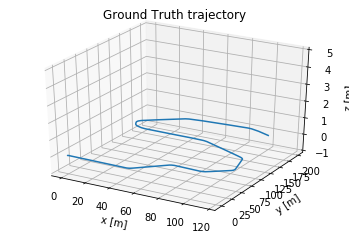

In [3]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

In [4]:
C_li = np.array([
    [ 0.99376, -0.09722,  0.05466],
    [ 0.09971,  0.99401, -0.04475],
    [-0.04998,  0.04992,  0.9975 ]
])

# This is an incorrect calibration rotation matrix, corresponding to a rotation of 0.05, 0.05, 0.05
# C_li = np.array([
#     [ 0.9975 , -0.04742,  0.05235],
#     [ 0.04992,  0.99763, -0.04742],
#     [-0.04998,  0.04992,  0.9975 ]
# ])

t_li_i = np.array([0.5, 0.1, 0.5])

lidar.data = (C_li @ lidar.data.T).T + t_li_i

Text(0.5, 1.0, 'gnss')

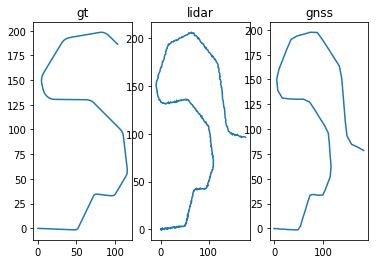

In [119]:
plt.subplot(131)
plt.plot(gt.p[:,0], gt.p[:,1])
plt.title("gt")

plt.subplot(132)
plt.plot(lidar.data[:, 0], lidar.data[:, 1])
plt.title("lidar")

plt.subplot(133)
plt.plot(gnss.data[:, 0], gnss.data[:, 1])
plt.title("gnss")

In [120]:
imu_w.data.shape

(10918, 3)

In [121]:
imu_f.data.shape

(10918, 3)

# Constants

In [122]:
################################################################################################
# This is the correct calibration rotation matrix, corresponding to an euler rotation of 0.05, 0.05, .1.
C_li = np.array([
    [ 0.99376, -0.09722,  0.05466],
    [ 0.09971,  0.99401, -0.04475],
    [-0.04998,  0.04992,  0.9975 ]
])

# This is an incorrect calibration rotation matrix, corresponding to a rotation of 0.05, 0.05, 0.05
# C_li = np.array([
#     [ 0.9975 , -0.04742,  0.05235],
#     [ 0.04992,  0.99763, -0.04742],
#     [-0.04998,  0.04992,  0.9975 ]
# ])

t_li_i = np.array([0.5, 0.1, 0.5])

lidar.data = (C_li @ lidar.data.T).T + t_li_i


#### 2. Constants ##############################################################################

################################################################################################
# Now that our data is set up, we can start getting things ready for our solver. One of the
# most important aspects of a filter is setting the estimated sensor variances correctly.
# We set the values here.
################################################################################################
var_imu_f = 0.1
var_imu_w = 1.0
var_gnss = 0.01
var_lidar = 0.25

################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian


#### 3. Initial Values #########################################################################

################################################################################################
# Let's set up some initial values for our ES-EKF solver.
################################################################################################
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.eye(9)  # covariance of estimate
gnss_i = 0
lidar_i = 0

# Measure Update

In [131]:
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    
    # 3.1 Compute Kalman Gain
    H = np.zeros([3, 9])
    H[:3, :3] = np.identity(3)  # [3, 9]
    if sensor_var == "gnss":
        R = np.identity(3) * var_gnss    # [3, 3]
    elif sensor_var == "lidar":
        R = np.identity(3) * var_lidar   # [3, 3]
    K = p_cov_check @ H.T @ np.linalg.inv(H @ p_cov_check @ H.T + R) # [9, 3]

    # 3.2 Compute error state
    delta_x = K @ (y_k - p_check[:3]) # [9] 

    # 3.3 Correct predicted state
    delta_p = delta_x[0:3] # [3]
    delta_v = delta_x[3:6] # [3]
    delta_phi = delta_x[6:9] # [3]

    p_check = p_check + delta_p
    v_check = v_check + delta_v
    q_check = Quaternion(axis_angle=delta_phi).quat_mult(q_check)

    # 3.4 Compute corrected covariance
    p_cov_check = (1 - K @ H) @ p_cov_check  # [9, 9]

    return p_check, v_check, q_check, p_cov_check

# Main 

In [135]:
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.eye(9)  # covariance of estimate
gnss_i = 0
lidar_i = 0

In [178]:
for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    p_last = p_est[k - 1]
    v_last = v_est[k - 1]
    q_last = q_est[k - 1]
    f_last = imu_f.data[k - 1]
    w_last = imu_w.data[k - 1]

    p_cov_last = p_cov[k - 1]
    

    # 1. Update state with IMU inputs
    
    Cns = Quaternion(*q_last).to_mat()
    
    # 1.1 Linearize Motion Model
    p_predict = p_last + delta_t * v_last + delta_t ** 2 / 2 * (Cns @ f_last - g)
    v_predict = v_last + delta_t * (Cns @ f_last - g)
    q_predict = Quaternion(axis_angle=w_last * delta_t).quat_mult(q_last)

    # 2. Propagate uncertainty
    
    F_last = np.identity(9)
    F_last[:3, 3:6] = np.identity(3) * delta_t
    F_last[3:6, -3:] = - skew_symmetric(Cns @ f_last) * delta_t

    Q_last = np.identity(6)
    Q_last[:, :3] *= delta_t**2 * var_imu_f
    Q_last[:, -3:] *= delta_t**2 * var_imu_w  # !!! f, w location

    p_cov_predict =  F_last @ p_cov_last @ F_last.T + l_jac @ Q_last @ l_jac.T

    # 3. Check availability of GNSS and LIDAR measurements
    curr_t = imu_f.t[k]

    #print ("init: ", p_predict[:3])
    ### lidar
    if len(np.where(lidar.t == curr_t)[0]) == 1:
        idx = np.where(lidar.t== curr_t)[0][0]
        p_predict, v_predict, q_predict, p_cov_predict = measurement_update("lidar", p_cov_predict, lidar.data[idx], p_predict, v_predict, q_predict)
        #print ("lidar: ", p_predict[:3])

    ## gnss 
    if len(np.where(gnss.t == curr_t)[0]) == 1:
        idx = np.where(gnss.t == curr_t)[0][0]
        p_predict, v_predict, q_predict, p_cov_predict = measurement_update("gnss", p_cov_predict, gnss.data[idx], p_predict, v_predict, q_predict)
        #print ("gnss: ", p_predict[:3])

    # 4. Update list values
    p_est[k] = p_predict
    v_est[k] = v_predict
    q_est[k] = q_predict
    p_cov[k] = p_cov_predict

# Plot

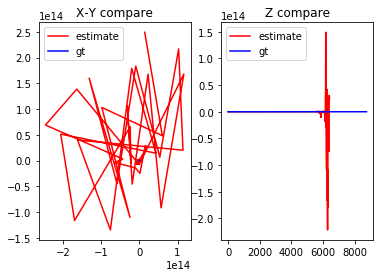

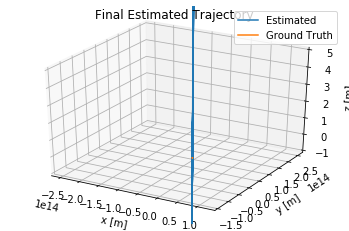

In [179]:
plt.subplot(121)
plt.plot(p_est[:,0], p_est[:,1], label='Estimated', color='r')
plt.plot(gt.p[:,0], gt.p[:,1], label='Ground Truth', color='b')
plt.title("X-Y compare")
plt.legend(['estimate', 'gt'])

plt.subplot(122)
plt.plot(p_est[:,2], color='r')
plt.plot(gt.p[:,2], color='b')
plt.title("Z compare")
plt.legend(['estimate', 'gt'])

#plt.subplot(123)

k = 400000
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:k,0], p_est[:k,1], p_est[:k,2], label='Estimated')
ax.plot(gt.p[:k,0], gt.p[:k,1], gt.p[:k,2], label='Ground Truth')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Final Estimated Trajectory')
ax.legend()
ax.set_zlim(-1, 5)
plt.show()